In [23]:
#IMPORT PACKAGES & DATA
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

train = pd.read_csv('/Users/wpool1/Desktop/nyc-taxi-trip-duration/train.csv')
test = pd.read_csv('/Users/wpool1/Desktop//nyc-taxi-trip-duration/test.csv')

In [24]:
#CREATE DATETIME FEATURES
#train set
train['pickup_datetime'] = pd.to_datetime(train['pickup_datetime'])
train['pickup_weekday'] = train['pickup_datetime'].dt.weekday
train['pickup_hour'] = train['pickup_datetime'] .dt.hour
train['pickup_weekday_hour'] = train['pickup_weekday'] * 24 + train['pickup_hour']

#test set
test['pickup_datetime'] = pd.to_datetime(train['pickup_datetime'])
test['pickup_weekday'] = test['pickup_datetime'].dt.weekday
test['pickup_hour'] = test['pickup_datetime'] .dt.hour
test['pickup_weekday_hour'] = test['pickup_weekday'] * 24 + train['pickup_hour']

In [25]:
#CREATE LOCATION FEATURES
#pass thru coordinates
train['passthru_latitude'] = (train['pickup_latitude'] + train['dropoff_latitude']) / 2
train['passthru_longitude'] = (train['pickup_longitude'] + train['dropoff_longitude']) / 2
test['passthru_latitude'] = (test['pickup_latitude'] + test['dropoff_latitude']) / 2
test['passthru_longitude'] = (test['pickup_longitude'] + test['dropoff_longitude']) / 2

#location clusters
from sklearn.cluster import MiniBatchKMeans

#I used multiple clusters for pickup, passthru, dropoff points
#since I figured drop off points and pick up points may exhibit
#different behavior in how they are concentrated.

kmeans_pickup = MiniBatchKMeans(n_clusters=100, batch_size=10000).fit(train[['pickup_latitude','pickup_longitude']].values)
train['pickup_cluster'] = kmeans_pickup.predict(train[['pickup_latitude','pickup_longitude']])
test['pickup_cluster'] = kmeans_pickup.predict(test[['pickup_latitude','pickup_longitude']])

kmeans_dropoff = MiniBatchKMeans(n_clusters=100, batch_size=10000).fit(train[['dropoff_latitude','dropoff_longitude']].values)
train['dropoff_cluster'] = kmeans_pickup.predict(train[['dropoff_latitude','dropoff_longitude']])
test['dropoff_cluster'] = kmeans_pickup.predict(test[['dropoff_latitude','dropoff_longitude']])

kmeans_passthru = MiniBatchKMeans(n_clusters=100, batch_size=10000).fit(train[['passthru_latitude','passthru_longitude']].values)
train['passthru_cluster'] = kmeans_pickup.predict(train[['passthru_latitude','passthru_longitude']])
test['passthru_cluster'] = kmeans_pickup.predict(test[['passthru_latitude','passthru_longitude']])

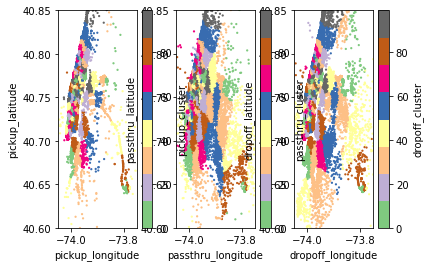

In [26]:
#visualize clusters
fig, ax = plt.subplots(ncols=3)
N = 100000
train[:N].plot(kind='scatter', x='pickup_longitude', y='pickup_latitude', c='pickup_cluster', cmap='Accent', s=5, lw=0, ax=ax[0])
train[:N].plot(kind='scatter', x='passthru_longitude', y='passthru_latitude', c='passthru_cluster', cmap='Accent', s=5, lw=0, ax=ax[1])
train[:N].plot(kind='scatter', x='dropoff_longitude', y='dropoff_latitude', c='dropoff_cluster', cmap='Accent', s=5, lw=0, ax=ax[2])
for i in range(3):
	ax[i].set_xlim(-74.05,-73.75)
	ax[i].set_ylim(40.60, 40.85)
plt.show()

In [27]:
# I noticed that pass thru clusters were not particularly useful
#since clustered areas covered both land and water so I remove this feature from the model.

del train['passthru_cluster']

#I do keep passthru coordinates however as they may still be useful.

In [29]:
#CREATE DISTANCE FEATURES
def haversine_distance(lat1, lat2, lon1, lon2):
	lat1, lat2, lon1, lon2 = map(np.radians, [lat1, lat2, lon1, lon2])
	latd = lat1 - lat2
	lond = lon1 - lon2
	a = np.sin(latd/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(lond/2)**2
	c = 2 * np.arcsin(np.sqrt(a))
	km = 6367 * c
	return km

def manhattan_distance(lat1, lat2, lon1, lon2):
	x = haversine_distance(lat1, lat2, lon1, lon1)
	y = haversine_distance(lat1, lat1, lon1, lon2)
	km = x + y
	return km

train['haversine_distance'] = haversine_distance(train['pickup_latitude'], train['dropoff_latitude'], train['pickup_longitude'], train['dropoff_longitude'])
train['manhattan_distance'] = manhattan_distance(train['pickup_latitude'], train['dropoff_latitude'], train['pickup_longitude'], train['dropoff_longitude'])
test['haversine_distance'] = haversine_distance(test['pickup_latitude'], test['dropoff_latitude'], test['pickup_longitude'], test['dropoff_longitude'])
test['manhattan_distance'] = manhattan_distance(test['pickup_latitude'], test['dropoff_latitude'], test['pickup_longitude'], test['dropoff_longitude'])

In [30]:
#CREATE AVG SPEED FEATURES
train['haversine_speed'] = train['haversine_distance'] / (train['trip_duration']/60/60)
train['manhattan_speed'] = train['manhattan_distance'] / (train['trip_duration']/60/60)

#remove outliers based on speed
train = train[train['manhattan_speed'] > 0] #Any taxi which did not travel at all (0.4% of instances)
train = train[train['manhattan_speed'] < 100] #Any taxi which travelled faster than 100km/hr on average (0.01% of instances)

avg_speed_groups = [
	'pickup_weekday',
	'pickup_hour',
	'pickup_weekday_hour',
	'pickup_cluster',
	'dropoff_cluster',
	['pickup_cluster', 'pickup_hour'],
	['dropoff_cluster', 'pickup_hour'],
	['pickup_cluster', 'dropoff_cluster']
]

for g in avg_speed_groups:
	gname = '_'.join(g) if type(g) == list else g
	avg_speed = train.groupby(g)[['haversine_speed','manhattan_speed']].mean()\
		.rename(columns={'haversine_speed':'avg_%s_haversine_speed' % gname,'manhattan_speed':'avg_%s_manhattan_speed' % gname})\
		.reset_index()
	train = train.merge(avg_speed, on=g, how='left')
	test = test.merge(avg_speed, on=g, how='left')

In [31]:
#RANDOM FOREST REGRESSOR
from sklearn.ensemble import RandomForestRegressor
from sklearn.cross_validation import train_test_split

train['store_and_fwd_flag'] = (train['store_and_fwd_flag'] == 'Y').astype(int)
test['store_and_fwd_flag'] = (test['store_and_fwd_flag'] == 'Y').astype(int)

features = [
	'passenger_count',
	'pickup_longitude',
	'pickup_latitude',
	'dropoff_longitude',
	'dropoff_latitude',
	'store_and_fwd_flag',
	'pickup_weekday',
	'pickup_hour',
	'pickup_weekday_hour',
	'passthru_latitude',
	'passthru_longitude',
	'pickup_cluster',
	'dropoff_cluster',
	'haversine_distance',
	'manhattan_distance',
	'avg_pickup_weekday_haversine_speed',
	'avg_pickup_weekday_manhattan_speed',
	'avg_pickup_hour_haversine_speed',
	'avg_pickup_hour_manhattan_speed',
	'avg_pickup_weekday_hour_haversine_speed',
	'avg_pickup_weekday_hour_manhattan_speed',
	'avg_pickup_cluster_haversine_speed',
	'avg_pickup_cluster_manhattan_speed',
	'avg_dropoff_cluster_haversine_speed',
	'avg_dropoff_cluster_manhattan_speed',
	'avg_pickup_cluster_pickup_hour_haversine_speed',
	'avg_pickup_cluster_pickup_hour_manhattan_speed',
	'avg_dropoff_cluster_pickup_hour_haversine_speed',
	'avg_dropoff_cluster_pickup_hour_manhattan_speed',
	'avg_pickup_cluster_dropoff_cluster_haversine_speed',
	'avg_pickup_cluster_dropoff_cluster_manhattan_speed'
]


regr = RandomForestRegressor(max_depth=10, criterion='mse')
#Unfortunately RandomForestRegressor does not have 'rmsle' or rmse' criterion
#so I used 'mse' with log(trip_duration) as target

X = train[features].values
y = np.log(train['trip_duration'].values + 1) 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
regr.fit(X_train, y_train)
y_train_pred = regr.predict(X_train)
y_test_pred = regr.predict(X_test)

In [32]:
from sklearn.metrics import mean_squared_error
print('RMSLE of train set: ', np.sqrt(mean_squared_error(y_train, y_train_pred)))
print('RMSLE of test set: ', np.sqrt(mean_squared_error(y_test, y_test_pred)))

RMSLE of train set:  0.397595685376
RMSLE of test set:  0.403047496874


In [33]:
#FINAL OUTPUT

#Filling in NA values in test set with median values:

#RandomForestRegressor does not handle NA values.
#Unfortunately 518 instances (0.08% of all instances) in the test data set contained a column with an NA value.
#I've filled these NA values with the median value for that column.
#While this is not the most elegant solution, the number of instances are so few that 
#I felt the overall impact would be very small. 
#It's also worth noting that xgboost can handle NA values, 
#and had I taken the xgboost approach this would not have been an issue.

X = test[features].fillna(test[features].mean()).values
y = regr.predict(X)
test['trip_duration'] = np.exp(y) - 1
output = test[['id','trip_duration']]